In [56]:
import numpy as np
import preprocessing as pp

from graph import *
from bayesian_decision_evaluation import *

import models
from models.multivariate_gaussian_classifier import *


In [57]:
X, y = utils.load_data()

classes = {
    'Fake': 'blue',
    'Real': 'orange'
}

#### Analyze the performance of the MVG classifier and its variants for different applications.
Start considering five applications, given by (π1,Cfn,Cfp):

In [58]:

def print_prior_prob(pi, cost_fp, cost_fn):
    cost_matrix, prior_class_prob, threshold = binary_cost_matrix(pi, cost_fp, cost_fn)
    print(f"pi: {pi}, prior_class_prob: {prior_class_prob}, cost_fp: {cost_fp}, cost_fn: {cost_fn}, threshold: {threshold:.4f}")
    print(f"Cost matrix:")
    for i in range(cost_matrix.shape[0]):
        print(f"\t{cost_matrix[i]}")
    print()

print_prior_prob(0.5, 1, 1)
print_prior_prob(0.9, 1, 1)
print_prior_prob(0.1, 1, 1)
print_prior_prob(0.5, 1, 9)
print_prior_prob(0.5, 9, 1)

pi: 0.5, prior_class_prob: [0.5 0.5], cost_fp: 1, cost_fn: 1, threshold: -0.0000
Cost matrix:
	[0 1]
	[1 0]

pi: 0.9, prior_class_prob: [0.1 0.9], cost_fp: 1, cost_fn: 1, threshold: -2.1972
Cost matrix:
	[0 1]
	[1 0]

pi: 0.1, prior_class_prob: [0.9 0.1], cost_fp: 1, cost_fn: 1, threshold: 2.1972
Cost matrix:
	[0 1]
	[1 0]

pi: 0.5, prior_class_prob: [0.5 0.5], cost_fp: 1, cost_fn: 9, threshold: -2.1972
Cost matrix:
	[0 9]
	[1 0]

pi: 0.5, prior_class_prob: [0.5 0.5], cost_fp: 9, cost_fn: 1, threshold: 2.1972
Cost matrix:
	[0 1]
	[9 0]



For each application, compute the optimal Bayes decisions for the validation set for the MVG models and its variants, with and without PCA (try different values of m). Compute DCF (actual) and minimum DCF for the different models. Compare the models in terms of minimum DCF. 

In [59]:
def compute_statistics(llr, y_true, pi, C_fp=1, C_fn=1, unique_labels=None, plot_graph=False):
    cost_matrix, prior_class_prob, _ = binary_cost_matrix(pi, C_fp, C_fn)
    
    minDCF, best_threshold = compute_minDCF(llr, y_true, pi, unique_labels)
    
    y_pred = np.where(llr > best_threshold, 1, 0)
    cm = confusion_matrix(y_true, y_pred)
    for i in range(cm.shape[0]):
        print(f"\t{cm[i]}")
    DCF, _, _ = compute_DCF(cm, cost_matrix, prior_class_prob)
    DCF_norm, _, _ = compute_DCF_normalized(cm, cost_matrix, prior_class_prob)
    acc = accuracy(cm)
    
    print(f"\tminDCF: {minDCF:.4f}, DCf: {DCF:.4f}, DCF_norm: {DCF_norm:.4f}, accuracy: {acc*100:.2f}%, threshold: {best_threshold:.4f}")
    print()
    if plot_graph:
        plot_ROC_curve(llr, y_true, cost_matrix, prior_class_prob, unique_labels)
        plot_bayes_error(llr, y_true, unique_labels)
    
    return minDCF, acc

In [60]:
def compute_accuracy(llr, prior, y_true, unique_labels=None, th_req=False):
    if unique_labels is None:
        unique_labels = np.unique(y_true)

    _, threshold = compute_minDCF(llr, y_true, prior, unique_labels)
    y_pred = np.where(llr > threshold, unique_labels[1], unique_labels[0])
    cm = confusion_matrix(y_true, y_pred)
    
    acc = accuracy(cm)
    if th_req:
        return acc, threshold
    return acc

In [61]:
models_dict = {
    'MVG': MultivariateGaussianClassifier(),
    'NB': NaiveBayesClassifier(),
    'TC': TiedCovarianceClassifier(),
}

#### Raw data

In [62]:
X_train, y_train, X_test, y_test = utils.split_data(X, y)
pie = [0.1, 0.5, 0.9]

for pi in pie:
    print(f"Prior probability: {pi}")
    for model_name, model in models_dict.items():
        print(f"\tModel: {model_name}")
        model.set_prior(pi)
        model.fit(X_train, y_train)
        llr = model.score_binary(X_test, y)
        
        compute_statistics(llr, y_test, pi, unique_labels=np.unique(y))

Prior probability: 0.1
	Model: MVG
	[985.   7.]
	[201. 807.]
	minDCF: 0.2629, DCf: 0.0263, DCF_norm: 0.2629, accuracy: 89.60%, threshold: 1.5372

	Model: NB
	[985.   7.]
	[195. 813.]
	minDCF: 0.2570, DCf: 0.0257, DCF_norm: 0.2570, accuracy: 89.90%, threshold: 1.5281

	Model: TC
	[980.  12.]
	[256. 752.]
	minDCF: 0.3628, DCf: 0.0363, DCF_norm: 0.3628, accuracy: 86.60%, threshold: 1.7163

Prior probability: 0.5
	Model: MVG
	[917.  75.]
	[ 55. 953.]
	minDCF: 0.1302, DCf: 0.0651, DCF_norm: 0.1302, accuracy: 93.50%, threshold: -0.2233

	Model: NB
	[919.  73.]
	[ 58. 950.]
	minDCF: 0.1311, DCf: 0.0656, DCF_norm: 0.1311, accuracy: 93.45%, threshold: -0.1791

	Model: TC
	[887. 105.]
	[ 76. 932.]
	minDCF: 0.1812, DCf: 0.0906, DCF_norm: 0.1812, accuracy: 90.95%, threshold: -0.2238

Prior probability: 0.9
	Model: MVG
	[803. 189.]
	[ 17. 991.]
	minDCF: 0.3423, DCf: 0.0342, DCF_norm: 0.3423, accuracy: 89.70%, threshold: -1.6198

	Model: NB
	[821. 171.]
	[ 20. 988.]
	minDCF: 0.3510, DCf: 0.0351, DCF

In [63]:
for model_name, model in models_dict.items():
    print(f"Model: {model_name}")
    model.fit(X_train, y_train)
    llr = model.score_binary(X_test, y)
    acc, threshold = compute_accuracy(llr, 0.5, y_test, th_req=True)
    print(f"\tAccuracy: {acc*100:.2f}%, threshold: {threshold:.4f}")

Model: MVG
	Accuracy: 93.50%, threshold: -0.2233
Model: NB
	Accuracy: 93.45%, threshold: -0.1791
Model: TC
	Accuracy: 90.95%, threshold: -0.2238


#### PCA data

In [64]:
def compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models, pi):
    results = {model_name: [] for model_name in models.keys()}
    
    for i in reversed(range(X_train.shape[0])):
        X_train_pca, eig_v = pp.pca(data=X_train, n_features=i+1, required_eigen_vectors=True)
        X_test_pca = np.dot(eig_v.T, X_test)
        
        for model_name, model in models.items():
            model.fit(X_train_pca, y_train)
            llr = model.score_binary(X_test_pca, y_test)
            minDCF, acc = compute_statistics(llr, y_test, pi)
            results[model_name].append((i+1, acc, minDCF))
    
    plt.figure(figsize=(10, 6))
    
    for model_name, acc in results.items():
        features, accuracies, _ = zip(*acc)
        plt.plot(features, accuracies, marker='o', label=model_name)
        
    plt.xlabel('Number of PCA features')
    plt.ylabel('Accuracy')
    plt.title('Model accuracy with Varying PCA Features')
    plt.legend()
    plt.grid(True)
    plt.gca()
    plt.show()
    
    return results

	[985.   7.]
	[201. 807.]
	minDCF: 0.2629, DCf: 0.0263, DCF_norm: 0.2629, accuracy: 89.60%, threshold: 1.5372

	[983.   9.]
	[274. 734.]
	minDCF: 0.3535, DCf: 0.0353, DCF_norm: 0.3535, accuracy: 85.85%, threshold: 1.8433

	[980.  12.]
	[256. 752.]
	minDCF: 0.3628, DCf: 0.0363, DCF_norm: 0.3628, accuracy: 86.60%, threshold: 1.7163

	[985.   7.]
	[212. 796.]
	minDCF: 0.2738, DCf: 0.0274, DCF_norm: 0.2738, accuracy: 89.05%, threshold: 1.6363

	[983.   9.]
	[275. 733.]
	minDCF: 0.3545, DCf: 0.0354, DCF_norm: 0.3545, accuracy: 85.80%, threshold: 1.8704

	[980.  12.]
	[258. 750.]
	minDCF: 0.3648, DCf: 0.0365, DCF_norm: 0.3648, accuracy: 86.50%, threshold: 1.7285

	[981.  11.]
	[203. 805.]
	minDCF: 0.3012, DCf: 0.0301, DCF_norm: 0.3012, accuracy: 89.30%, threshold: 1.4257

	[983.   9.]
	[282. 726.]
	minDCF: 0.3614, DCf: 0.0361, DCF_norm: 0.3614, accuracy: 85.45%, threshold: 1.9132

	[979.  13.]
	[245. 763.]
	minDCF: 0.3610, DCf: 0.0361, DCF_norm: 0.3610, accuracy: 87.10%, threshold: 1.6243

	

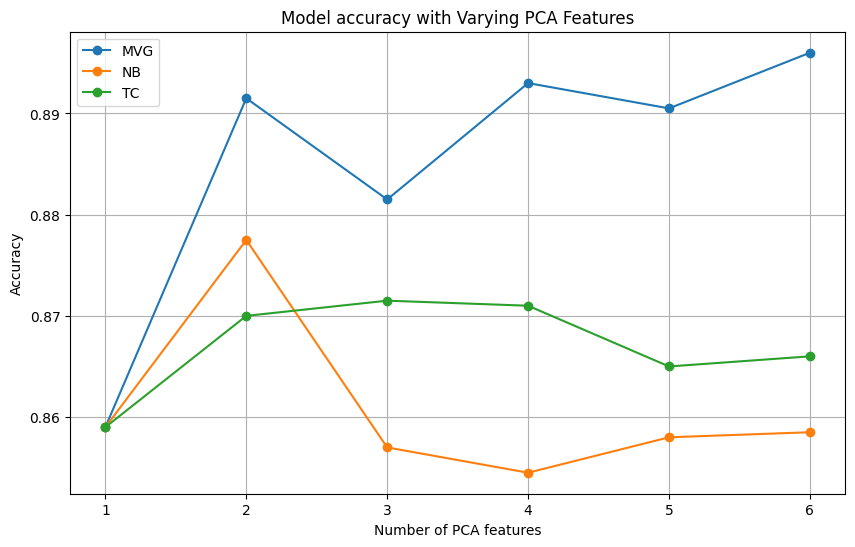

MVG - Best Accuracy: (6, 0.896, 0.2629128264208909)
NB - Best Accuracy: (2, 0.8775, 0.35618279569892475)
TC - Best Accuracy: (3, 0.8715, 0.3680875576036866)


In [65]:
pi = 0.1
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, pi)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

In [66]:
for model_name, acc in res.items():
    print(f'{model_name} - Best minDCF: {min(acc, key=lambda x: x[2])}')

MVG - Best minDCF: (6, 0.896, 0.2629128264208909)
NB - Best minDCF: (6, 0.8585, 0.3534786226318484)
TC - Best minDCF: (4, 0.871, 0.3609991039426523)


	[917.  75.]
	[ 55. 953.]
	minDCF: 0.1302, DCf: 0.0651, DCF_norm: 0.1302, accuracy: 93.50%, threshold: -0.2233

	[925.  67.]
	[106. 902.]
	minDCF: 0.1727, DCf: 0.0863, DCF_norm: 0.1727, accuracy: 91.35%, threshold: 0.2354

	[887. 105.]
	[ 76. 932.]
	minDCF: 0.1812, DCf: 0.0906, DCF_norm: 0.1812, accuracy: 90.95%, threshold: -0.2238

	[917.  75.]
	[ 58. 950.]
	minDCF: 0.1331, DCf: 0.0666, DCF_norm: 0.1331, accuracy: 93.35%, threshold: -0.2228

	[925.  67.]
	[107. 901.]
	minDCF: 0.1737, DCf: 0.0868, DCF_norm: 0.1737, accuracy: 91.30%, threshold: 0.2406

	[892. 100.]
	[ 81. 927.]
	minDCF: 0.1812, DCf: 0.0906, DCF_norm: 0.1812, accuracy: 90.95%, threshold: -0.1814

	[933.  59.]
	[ 95. 913.]
	minDCF: 0.1537, DCf: 0.0769, DCF_norm: 0.1537, accuracy: 92.30%, threshold: 0.2574

	[927.  65.]
	[107. 901.]
	minDCF: 0.1717, DCf: 0.0858, DCF_norm: 0.1717, accuracy: 91.40%, threshold: 0.2482

	[895.  97.]
	[ 85. 923.]
	minDCF: 0.1821, DCf: 0.0911, DCF_norm: 0.1821, accuracy: 90.90%, threshold: -0.11

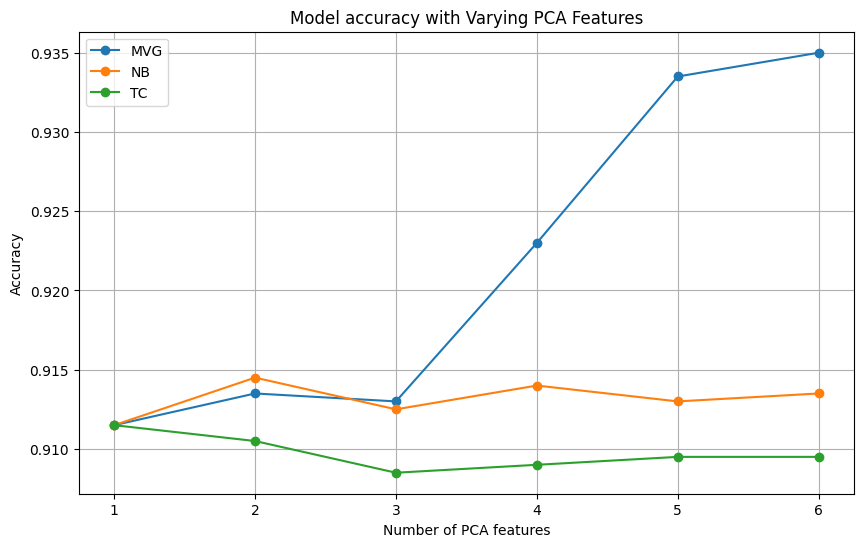

MVG - Best Accuracy: (6, 0.935, 0.13016833077316947)
NB - Best Accuracy: (2, 0.9145, 0.1710189452124936)
TC - Best Accuracy: (1, 0.9115, 0.17690732206861237)


In [67]:
pi = 0.5
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, pi)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

In [68]:
for model_name, acc in res.items():
    print(f'{model_name} - Best minDCF: {min(acc, key=lambda x: x[2])}')

MVG - Best minDCF: (6, 0.935, 0.13016833077316947)
NB - Best minDCF: (2, 0.9145, 0.1710189452124936)
TC - Best minDCF: (1, 0.9115, 0.17690732206861237)


	[803. 189.]
	[ 17. 991.]
	minDCF: 0.3423, DCf: 0.0342, DCF_norm: 0.3423, accuracy: 89.70%, threshold: -1.6198

	[781. 211.]
	[ 25. 983.]
	minDCF: 0.4359, DCf: 0.0436, DCF_norm: 0.4359, accuracy: 88.20%, threshold: -1.4419

	[704. 288.]
	[ 17. 991.]
	minDCF: 0.4421, DCf: 0.0442, DCF_norm: 0.4421, accuracy: 84.75%, threshold: -2.0126

	[803. 189.]
	[ 18. 990.]
	minDCF: 0.3512, DCf: 0.0351, DCF_norm: 0.3512, accuracy: 89.65%, threshold: -1.6358

	[774. 218.]
	[ 24. 984.]
	minDCF: 0.4340, DCf: 0.0434, DCF_norm: 0.4340, accuracy: 87.90%, threshold: -1.5653

	[701. 291.]
	[ 17. 991.]
	minDCF: 0.4451, DCf: 0.0445, DCF_norm: 0.4451, accuracy: 84.60%, threshold: -2.0337

	[784. 208.]
	[ 23. 985.]
	minDCF: 0.4150, DCf: 0.0415, DCF_norm: 0.4150, accuracy: 88.45%, threshold: -1.5366

	[759. 233.]
	[ 22. 986.]
	minDCF: 0.4313, DCf: 0.0431, DCF_norm: 0.4313, accuracy: 87.25%, threshold: -1.7147

	[702. 290.]
	[ 17. 991.]
	minDCF: 0.4441, DCf: 0.0444, DCF_norm: 0.4441, accuracy: 84.65%, threshold: -

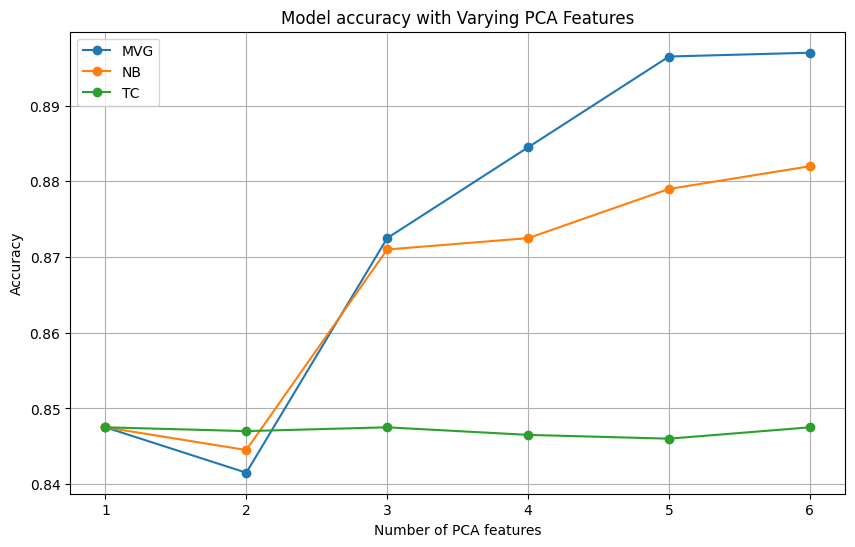

MVG - Best Accuracy: (6, 0.897, 0.34230990783410137)
NB - Best Accuracy: (6, 0.882, 0.43591589861751157)
TC - Best Accuracy: (6, 0.8475, 0.4421082949308756)


In [69]:
pi = 0.9
res = compute_accuracy_model_pca(X_train, y_train, X_test, y_test, models_dict, pi)
for model_name, acc in res.items():
    print(f'{model_name} - Best Accuracy: {max(acc, key=lambda x: x[1])}')

In [70]:
for model_name, acc in res.items():
    print(f'{model_name} - Best minDCF: {min(acc, key=lambda x: x[2])}')

MVG - Best minDCF: (6, 0.897, 0.34230990783410137)
NB - Best minDCF: (4, 0.8725, 0.431307603686636)
TC - Best minDCF: (3, 0.8475, 0.4341877880184332)


#### Best Model with the lowest minimum DCF: MVG with PCA 6

Model: MVG
	[985.   7.]
	[201. 807.]
	minDCF: 0.2629, DCf: 0.0263, DCF_norm: 0.2629, accuracy: 89.60%, threshold: 1.5372



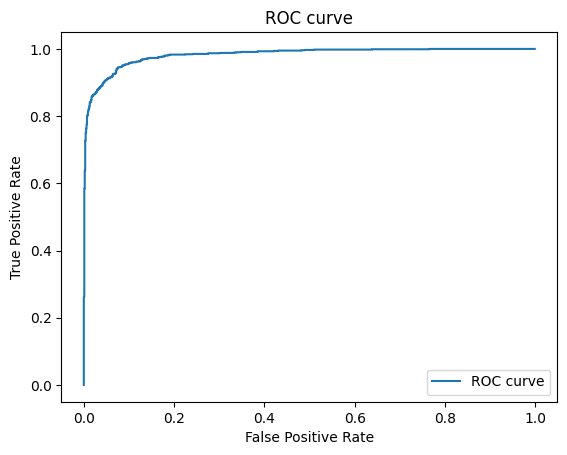

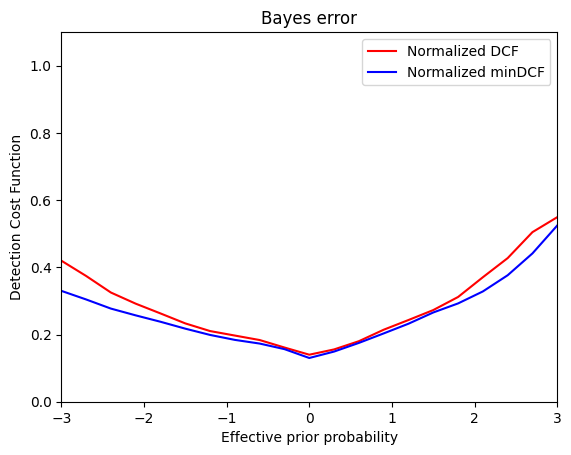

Model: NB
	[983.   9.]
	[274. 734.]
	minDCF: 0.3535, DCf: 0.0353, DCF_norm: 0.3535, accuracy: 85.85%, threshold: 1.8433



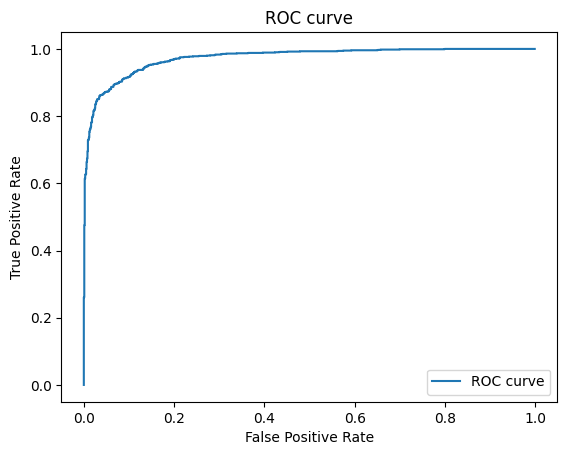

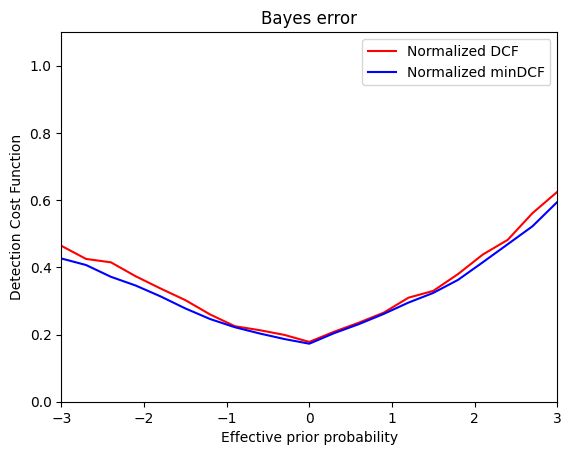

Model: TC
	[980.  12.]
	[256. 752.]
	minDCF: 0.3628, DCf: 0.0363, DCF_norm: 0.3628, accuracy: 86.60%, threshold: 1.7163



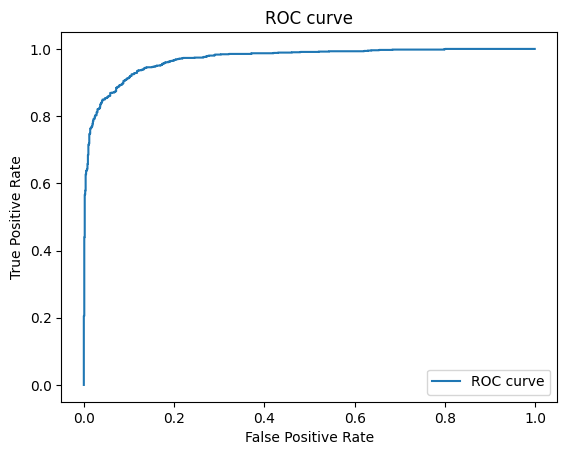

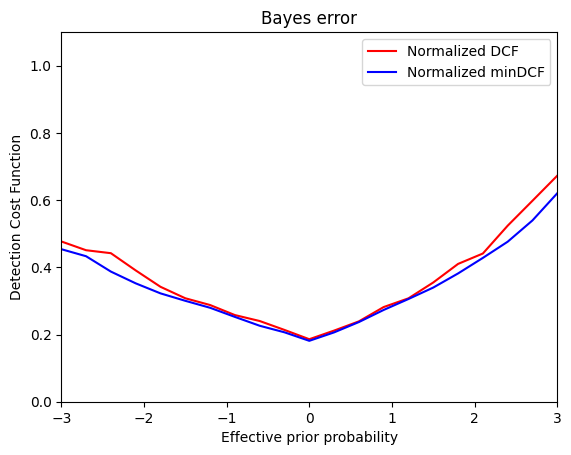

In [71]:
pi = 0.1

X_train, y_train, X_test, y_test = utils.split_data(X, y)
X_train_pca, eig_v = pp.pca(data=X_train, n_features=6, required_eigen_vectors=True)
X_test_pca = np.dot(eig_v.T, X_test)

models = {
    'MVG': MultivariateGaussianClassifier(),
    'NB': NaiveBayesClassifier(),
    'TC': TiedCovarianceClassifier(),
}

for model_name, model in models.items():
    print(f"Model: {model_name}")
    model.set_prior(pi)
    model.fit(X_train_pca, y_train)
    llr = model.score_binary(X_test_pca, y)
    compute_statistics(llr, y_test, pi, unique_labels=np.unique(y), plot_graph=True)